# Customer Conversion Prediction

### 1. Importing important libraries

In [230]:
#Importing the important libraries
import pandas as pd
import numpy as np

#Importing libraries for pre-porocessing of our data
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

#Importing libraries for plotting graph
import seaborn as sns
import matplotlib.pyplot as plt

#Importing Libaries for modeling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

### 2. Importing the dataset and displaying the summary

In [231]:
#Importing my traing dataset and getting an intial look on how data looks
act_data = pd.read_csv("C:\\Users\\ADMIN\\Downloads\\train.csv")
act_data = act_data.copy()

In [232]:
act_data

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes
45208,72,retired,married,secondary,cellular,17,nov,1127,5,success,yes
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,no


In [233]:
act_data.shape

(45211, 11)

In [234]:
act_data.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


### 3. Clean Data

##### 3.1 Finding missing Values

In [235]:
#Finding missing values in our data
act_data.isnull().sum()
#There are no missing values in our dataset

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

##### 3.2 Finding and deleting duplicate rows

In [236]:
act_data.shape

(45211, 11)

In [237]:
#Finding duplicate values and droping them
act_data = act_data.drop_duplicates()

In [238]:
act_data.shape

(45205, 11)

##### 3.3 Removing outliers from our numerical data

In [239]:
act_data.describe()

,age,day,dur,num_calls
count,45205.000000,45205.00000,45205.000000,45205.000000
mean,40.937087,15.80688,258.183055,2.763898
std,10.619130,8.32234,257.538504,3.098189
min,18.000000,1.00000,0.000000,1.000000
25%,33.000000,8.00000,103.000000,1.000000
50%,39.000000,16.00000,180.000000,2.000000
75%,48.000000,21.00000,319.000000,3.000000
max,95.000000,31.00000,4918.000000,63.000000


In [240]:
#Finding and clipping our data based on outliers using iqr technique
for i in act_data.select_dtypes(include=['int64', 'float64']):
        iqr = act_data[i].quantile(0.75) - act_data[i].quantile(0.25)
        upper_threshold = act_data[i].quantile(0.75) + (1.5 * iqr) # q3 + 1.5iqr
        lower_threshold = act_data[i].quantile(0.25) - (1.5 * iqr) # q1 - 1.5iqr
        act_data = act_data.copy()
        act_data[i] = act_data[i].clip(lower_threshold, upper_threshold)

In [241]:
act_data.describe()

,age,day,dur,num_calls
count,45205.000000,45205.00000,45205.00000,45205.000000
mean,40.869052,15.80688,234.95620,2.392235
std,10.395247,8.32234,176.75476,1.600152
min,18.000000,1.00000,0.00000,1.000000
25%,33.000000,8.00000,103.00000,1.000000
50%,39.000000,16.00000,180.00000,2.000000
75%,48.000000,21.00000,319.00000,3.000000
max,70.500000,31.00000,643.00000,6.000000


##### 3.4 Handling invalid data

In [242]:
#Frequency of unique elements in catogorical column
cat_cols = act_data.select_dtypes(include=object).columns.tolist()
(pd.DataFrame(act_data[cat_cols].melt(var_name='column', value_name='value').value_counts()).rename(columns={0: 'counts'}).sort_values(by=['column', 'counts']))

counts
column         value                
call_type      telephone        2906
               unknown         13017
               cellular        29282
education_qual unknown          1857
               primary          6850
               tertiary        13299
               secondary       23199
job            unknown           288
               student           938
               housemaid        1240
               unemployed       1303
               entrepreneur     1487
               self-employed    1579
               retired          2264
               services         4153
               admin.           5170
               technician       7596
               management       9457
               blue-collar      9730
marital        divorced         5207
               single          12788
               married         27210
mon            dec               214
               mar               477
               sep               579
               oct               738
               jan              1403
               feb              2649
               apr              2932
               nov              3970
               jun              5339
               aug              6245
               jul              6894
               may             13765
prev_outcome   success          1511
               other            1840
               failure          4901
               unknown         36953
y              yes              5289
               no              39916

In [243]:
#As we can see in education_qual and job column their are few unknown elements which can be replaced with mode
#Replacing unknown values in education_qual and job columns with mode
act_data = act_data.copy()
act_data['education_qual']=act_data['education_qual'].replace('unknown', act_data['education_qual'].mode()[0])
act_data['job']=act_data['job'].replace('unknown', act_data['job'].mode()[0])

#Also call_type and prev_outcome column have unknown values but their frequency is higher and can be treated as seprated element itself
#Renaming the unknown values so as to better analyse and does not coincide with each other
act_data['call_type']=act_data['call_type'].replace('unknown', 'unknown_call_type')
act_data['prev_outcome']=act_data['prev_outcome'].replace('unknown', 'unknown_prev_outcome')

In [244]:
#Frequency of unique elements in catogorical column after renaming
cat_cols = act_data.select_dtypes(include=object).columns.tolist()
(pd.DataFrame(act_data[cat_cols].melt(var_name='column', value_name='value').value_counts()).rename(columns={0: 'counts'}).sort_values(by=['column', 'counts']))

counts
column         value                       
call_type      telephone               2906
               unknown_call_type      13017
               cellular               29282
education_qual primary                 6850
               tertiary               13299
               secondary              25056
job            student                  938
               housemaid               1240
               unemployed              1303
               entrepreneur            1487
               self-employed           1579
               retired                 2264
               services                4153
               admin.                  5170
               technician              7596
               management              9457
               blue-collar            10018
marital        divorced                5207
               single                 12788
               married                27210
mon            dec                      214
               mar                      477
               sep                      579
               oct                      738
               jan                     1403
               feb                     2649
               apr                     2932
               nov                     3970
               jun                     5339
               aug                     6245
               jul                     6894
               may                    13765
prev_outcome   success                 1511
               other                   1840
               failure                 4901
               unknown_prev_outcome   36953
y              yes                     5289
               no                     39916

### 4. Exploratory data analysis (EDA)

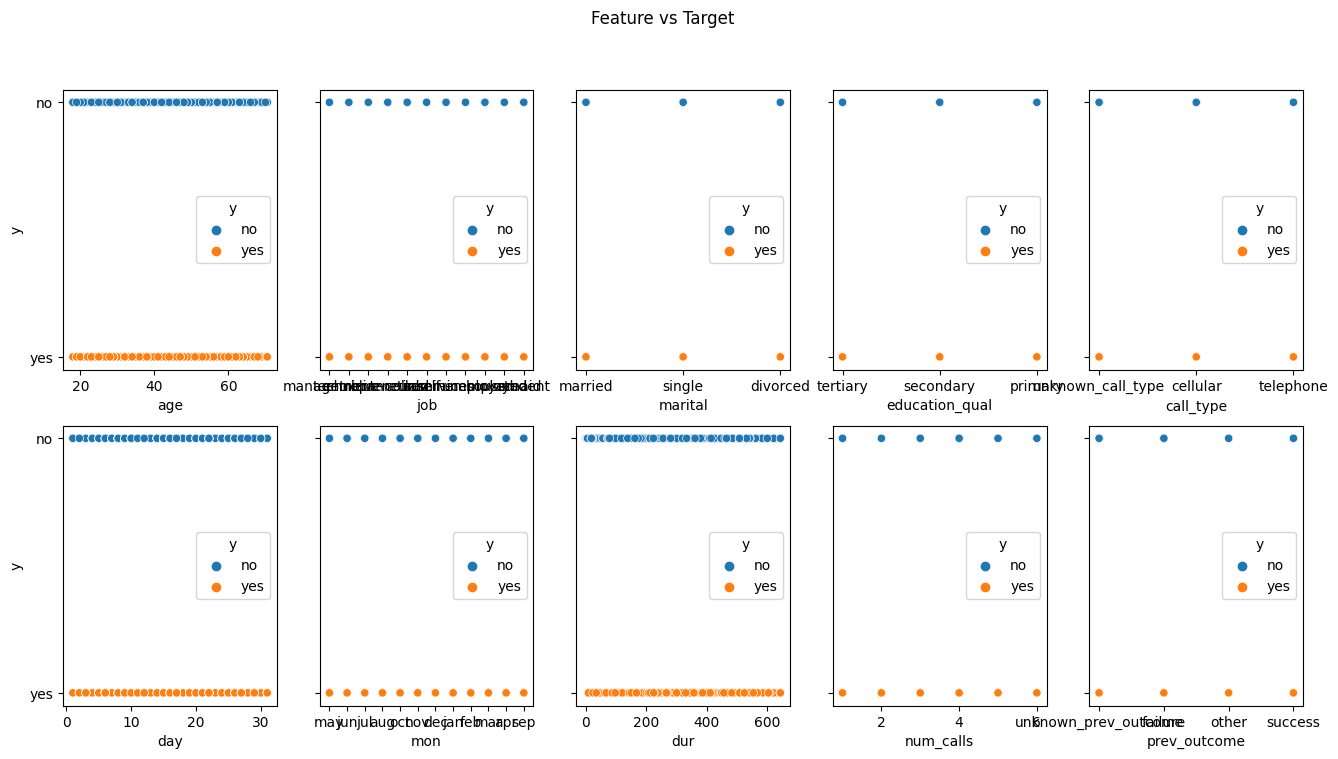

In [245]:
#Feature vs Target Plot
fig, axes = plt.subplots(2, 5, figsize=(16, 8), sharey=True)
fig.suptitle('Feature vs Target')
xc = 0
yc = 0
for i in act_data.columns[:-1]:
    sns.scatterplot(data=act_data, x=i, y='y', hue='y', ax=axes[xc, yc])
    yc = yc + 1
    if yc == 5:
        yc=0
        xc=1

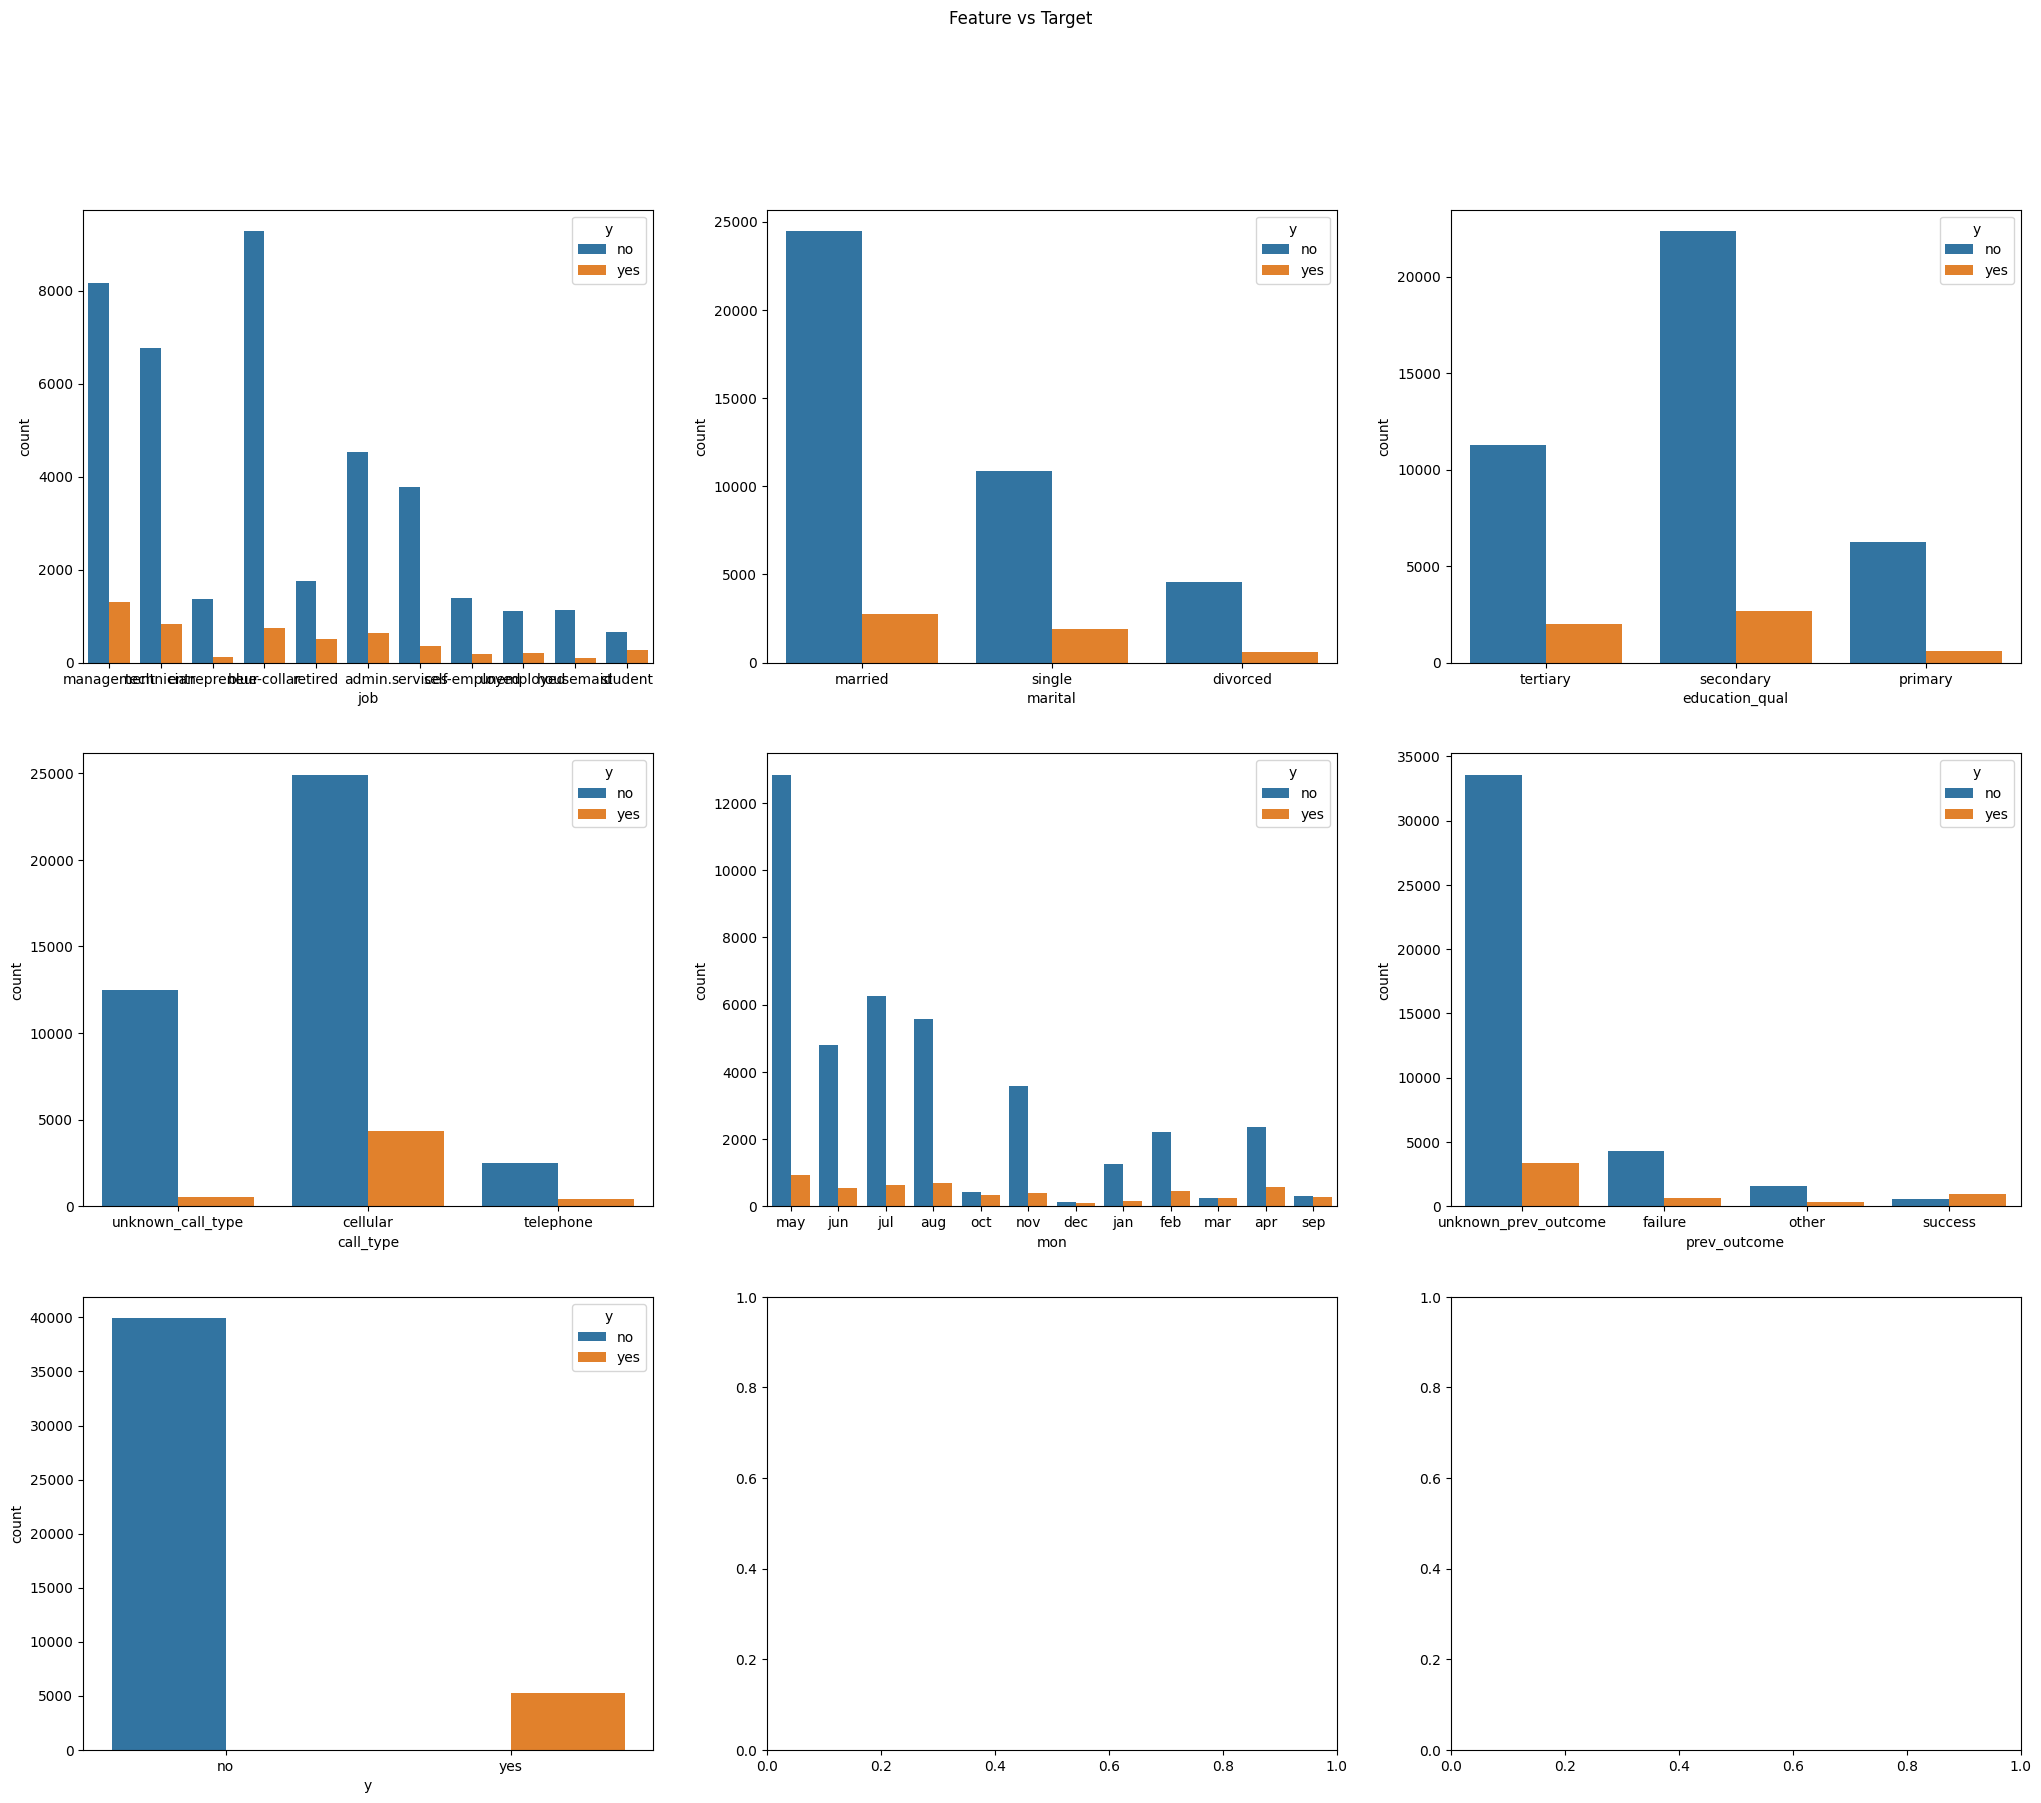

In [211]:
#Catogorical data count plot
fig, axes = plt.subplots(3, 3, figsize=(25, 20), sharey=False)
fig.suptitle('Feature vs Target')
xc = 0
yc = 0
for i in act_data.select_dtypes(include=['object'], exclude=['int64', 'float64']).columns:
    sns.countplot(x = i, data = act_data, hue='y', ax=axes[xc, yc])
    yc = yc + 1
    if yc == 3:
        yc=0
        xc=xc+1

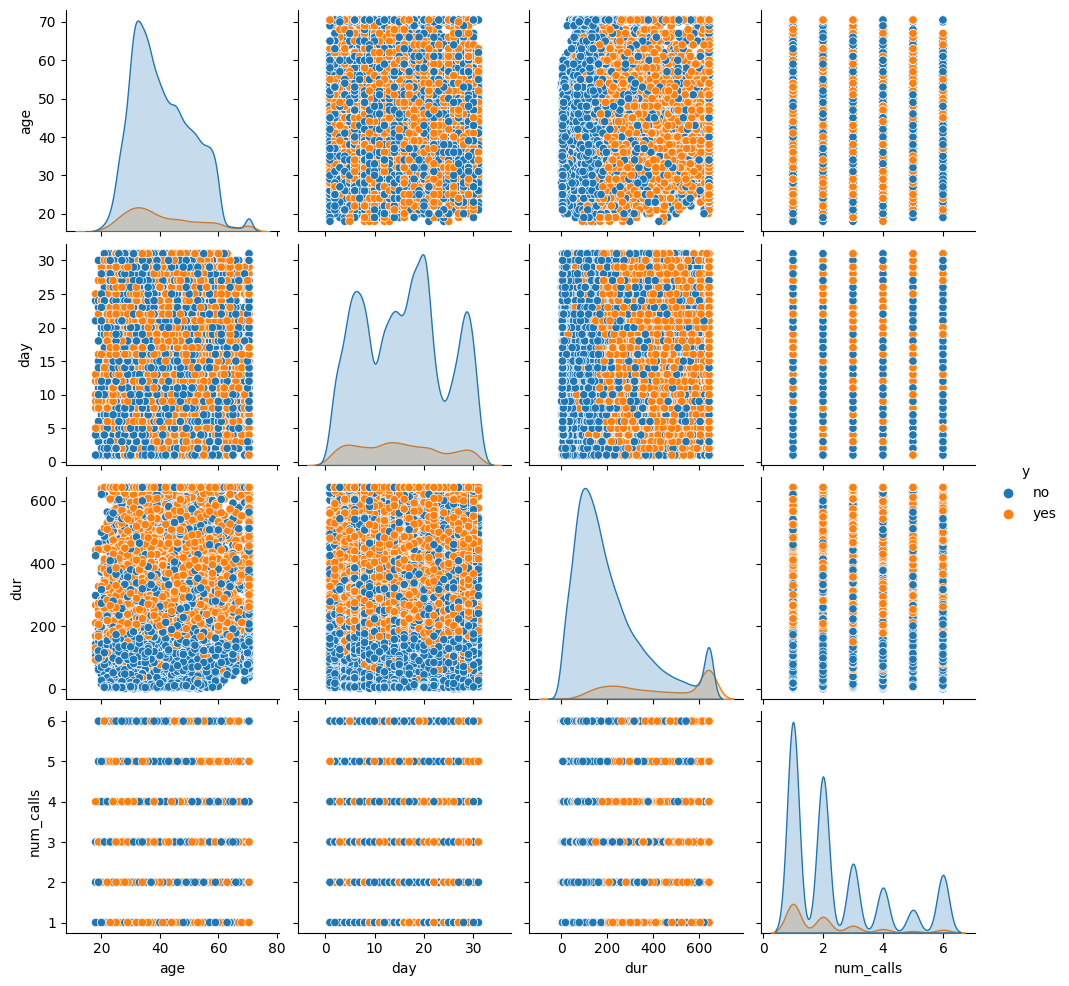

In [212]:
#Feature vs Feature (only numeric)
sns.pairplot(act_data, hue ='y')

In [112]:
"""
for i in act_data.select_dtypes(include=['object'], exclude=['int64', 'float64']).columns[:-1]:
    for j in act_data.select_dtypes(include=['object'], exclude=['int64', 'float64']).columns[:-1]:
        plt.figure(figsize=(20,5))
        plt.subplot(121)
        sns.countplot(data=act_data, x=i, hue=j)
"""

"\nfor i in act_data.select_dtypes(include=['object'], exclude=['int64', 'float64']).columns[:-1]:\n    for j in act_data.select_dtypes(include=['object'], exclude=['int64', 'float64']).columns[:-1]:\n        plt.figure(figsize=(20,5))\n        plt.subplot(121)\n        sns.countplot(data=act_data, x=i, hue=j)\n"

### 5. Encoding our categorical data

In [246]:
act_data

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58.0,management,married,tertiary,unknown_call_type,5,may,261,1,unknown_prev_outcome,no
1,44.0,technician,single,secondary,unknown_call_type,5,may,151,1,unknown_prev_outcome,no
2,33.0,entrepreneur,married,secondary,unknown_call_type,5,may,76,1,unknown_prev_outcome,no
3,47.0,blue-collar,married,secondary,unknown_call_type,5,may,92,1,unknown_prev_outcome,no
4,33.0,blue-collar,single,secondary,unknown_call_type,5,may,198,1,unknown_prev_outcome,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,technician,married,tertiary,cellular,17,nov,643,3,unknown_prev_outcome,yes
45207,70.5,retired,divorced,primary,cellular,17,nov,456,2,unknown_prev_outcome,yes
45208,70.5,retired,married,secondary,cellular,17,nov,643,5,success,yes
45209,57.0,blue-collar,married,secondary,telephone,17,nov,508,4,unknown_prev_outcome,no


In [247]:
for i in act_data.select_dtypes(include=['object'], exclude=['int64', 'float64']).columns[:-1]:
    
    # Get one hot encoding of job column
    one_hot = pd.get_dummies(act_data[i])
    # Drop column B as it is now encoded
    act_data = act_data.drop(i,axis = 1)
    # Join the encoded df
    act_data = act_data.join(one_hot)

In [248]:
#Get label encoding for y column
act_data["y"] = act_data["y"].map({"yes":1,"no":0}) #encoding binary class data (run only once)

In [249]:
act_data

,age,day,dur,num_calls,y,admin.,blue-collar,entrepreneur,housemaid,management,...,jun,mar,may,nov,oct,sep,failure,other,success,unknown_prev_outcome
0,58.0,5,261,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,44.0,5,151,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33.0,5,76,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47.0,5,92,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33.0,5,198,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,17,643,3,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45207,70.5,17,456,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45208,70.5,17,643,5,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
45209,57.0,17,508,4,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### 6. Split the dataset in train and test

In [250]:
#Spliting the dat into train and test
x = act_data[['age', 'day', 'dur', 'num_calls', 'admin.', 'blue-collar','entrepreneur', 'housemaid', 'management', 'retired',
              'self-employed','services', 'student', 'technician', 'unemployed', 'divorced','married', 'single', 'primary',
              'secondary', 'tertiary', 'cellular','telephone', 'unknown_call_type', 'apr', 'aug', 'dec', 'feb', 'jan','jul',
              'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'failure', 'other','success', 'unknown_prev_outcome']].values

y = act_data[['y']].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 101)

### 7. Balancing the dataset

In [251]:
#Balancing the dataset
smt = SMOTEENN(sampling_strategy='all')
x_train, y_train = smt.fit_resample(x_train, y_train)

### 8. Standardize the dataset

In [252]:
#Standarize the dataset before fitting it into the model
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [253]:
act_data

,age,day,dur,num_calls,y,admin.,blue-collar,entrepreneur,housemaid,management,...,jun,mar,may,nov,oct,sep,failure,other,success,unknown_prev_outcome
0,58.0,5,261,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,44.0,5,151,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33.0,5,76,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47.0,5,92,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33.0,5,198,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,17,643,3,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45207,70.5,17,456,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45208,70.5,17,643,5,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
45209,57.0,17,508,4,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [254]:
act_data.describe()

,age,day,dur,num_calls,y,admin.,blue-collar,entrepreneur,housemaid,management,...,jun,mar,may,nov,oct,sep,failure,other,success,unknown_prev_outcome
count,45205.000000,45205.00000,45205.00000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,...,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000,45205.000000
mean,40.869052,15.80688,234.95620,2.392235,0.117000,0.114368,0.221613,0.032895,0.027431,0.209203,...,0.118106,0.010552,0.304502,0.087822,0.016326,0.012808,0.108417,0.040703,0.033426,0.817454
std,10.395247,8.32234,176.75476,1.600152,0.321424,0.318261,0.415336,0.178363,0.163336,0.406744,...,0.322738,0.102180,0.460201,0.283039,0.126726,0.112448,0.310910,0.197605,0.179747,0.386298
min,18.000000,1.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,8.00000,103.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,16.00000,180.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,21.00000,319.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,70.500000,31.00000,643.00000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 9. Model, Loss, Learning, and Evaluation

In [255]:
class ClassificationModel:
    
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_test = x_test
        self.x_train = x_train
        self.y_train = y_train
        self.y_test = y_test
        
        
    def log_reg_model(self):

        log_reg = LogisticRegression() # initialise the model
        log_reg.fit(self.x_train, self.y_train) #training the data
        y_pred = log_reg.predict_proba(self.x_test) #Predicting
        roc = roc_auc_score(self.y_test, y_pred[:,1]) #Evaluation
        return roc
  

    def knn_model(self):
        
        #Finding the best value for K hyper parameter based on higest cv score
        '''
        khp = 0
        hcv = 0
        for i in [1,2,3,4,5,6,7,8,9,10]:
            knn = KNeighborsClassifier(i) #initialising the model
            knn.fit(x_train,y_train) # training the model
            if np.mean(cross_val_score(knn, x_train, y_train, cv=10, scoring = "roc_auc")) > hcv:
                hcv = np.mean(cross_val_score(knn, x_train, y_train, cv=10, scoring = "roc_auc"))
                khp = i
            else:
                break
        '''
        #Input the kbest K value and fit the model
        knn = KNeighborsClassifier(6)
        knn.fit(x_train,y_train)
        y_pred = knn.predict(x_test)
        roc = roc_auc_score(y_test, y_pred)
        
        return roc

    
    def dec_tree_model(self):

        dt = DecisionTreeClassifier(max_depth=9)
        dt.fit(self.x_train, self.y_train)
        y_pred = dt.predict(self.x_test)
        roc = roc_auc_score(self.y_test, y_pred)
        return roc
    
    def ens_model(self):

        model1 = LogisticRegression(random_state=1)
        model2 = tree.DecisionTreeClassifier(max_depth=9, random_state=1)
        model3 = KNeighborsClassifier(6)
        model = VotingClassifier(estimators=[('lr', model1), ('dt', model2),('knn',model3)], voting='soft') 
        model.fit(self.x_train, self.y_train)
        model.predict(self.x_test)
        y_pred = model.predict_proba(self.x_test)
        roc = roc_auc_score(self.y_test,y_pred[:,1])
        return roc
    
    def rf_model(self):

        rf = RandomForestClassifier(max_depth=10,n_estimators=100, max_features='sqrt')
        rf.fit(self.x_train, self.y_train) 
        y_pred = rf.predict(self.x_test)
        roc = roc_auc_score(self.y_test, y_pred)
        return roc
    
    def xg_model(self):
        
        model = XGBClassifier(learning_rate=0.5,n_estimators=100,verbosity=None)
        model.fit(self.x_train, self.y_train)
        y_pred = model.predict(self.x_test)
        roc = roc_auc_score(y_test, y_pred)
        return roc


In [281]:
clsmod = ClassificationModel(x_train, x_test, y_train, y_test) #Intialzie the class

temp_dict = {}

knn_score = clsmod.knn_model()
temp_dict['KNN'] = knn_score

log_reg_score = clsmod.log_reg_model()
temp_dict['Logestic Regression'] = log_reg_score

dec_score = clsmod.dec_tree_model()
temp_dict['Decision Tree'] = dec_score

ens_score = clsmod.ens_model()
temp_dict['Ensemble'] = ens_score

rf_score = clsmod.rf_model()
temp_dict['Random Forest'] = rf_score

xg_score = clsmod.xg_model()
temp_dict['XGBoost'] = xg_score

In [291]:
df = pd. DataFrame.from_dict(temp_dict, orient ='index', columns=['AUROC Score'])
df

,AUROC Score
KNN,0.783792
Logestic Regression,0.903671
Decision Tree,0.803360
Ensemble,0.914529
Random Forest,0.817811
XGBoost,0.820145


### 10. Feature Importance

In [224]:
# Finding feature imporatance using random forest classifier

rf = RandomForestClassifier(max_depth=10,n_estimators=100, max_features='sqrt')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
roc = roc_auc_score(y_test, y_pred)

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = act_data.columns[1:]

for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                    feat_labels[sorted_indices[f]],
                    importances[sorted_indices[f]]))

 1) num_calls                      0.410740
 2) cellular                       0.080198
 3) success                        0.066813
 4) unknown_call_type              0.049159
 5) unknown_prev_outcome           0.044525
 6) married                        0.033723
 7) blue-collar                    0.027470
 8) may                            0.022931
 9) tertiary                       0.021732
10) y                              0.018558
11) jul                            0.018170
12) day                            0.017583
13) single                         0.017525
14) secondary                      0.017493
15) aug                            0.016372
16) failure                        0.013846
17) nov                            0.010006
18) oct                            0.009991
19) primary                        0.009974
20) management                     0.009645
21) technician                     0.008892
22) dur                            0.008565
23) mar                         

In [223]:
#Ensemble model to present

model1 = LogisticRegression(random_state=1)
model2 = tree.DecisionTreeClassifier(max_depth=9, random_state=1)
model3 = KNeighborsClassifier(6)
model = VotingClassifier(estimators=[('lr', model1), ('dt', model2),('knn',model3)], voting='soft') 

model.fit(x_train, y_train)
model.predict(x_test)
y_pred = model.predict_proba(x_test)
roc = roc_auc_score(y_test,y_pred[:,1])
roc

0.9145098707566399